# Problem: 

**Şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?**

- Amaç bir bankanın müşterilerinin bankayı terk etme ya da terk etmeme durumunun tahmin edilmesidir.

- Müşteri terkini tanımlayan olay müşterinin banka hesabını kapatmasıdır.

**Veri Seti Hikayesi:**

- 10000 gözlemden ve 12 değişkenden oluşmaktadır. 
- Bağımsız değişkenler müşterilere ilişkin bilgiler barındırmaktadır.
- Bağımlı değişken müşteri terk durumunu ifade etmektedir.

**Değişkenler:**

- Surname : Soy isim
- CreditScore : Kredi skoru
- Geography : Ülke (Germany/France/Spain)
- Gender : Cinsiyet (Female/Male)
- Age : Yaş
- Tenure : Kaç yıllık müşteri
- Balance : Bakiye
- NumOfProducts : Kullanılan banka ürünü
- HasCrCard : Kredi kartı durumu (0=No,1=Yes)
- IsActiveMember : Aktif üyelik durumu (0=No,1=Yes)
- EstimatedSalary : Tahmini maaş
- Exited : Terk mi değil mi? (0=No,1=Yes)


# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [8]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn.csv


In [2]:
churn_data = pd.read_csv("churn.csv")

In [3]:
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
churn_data.info() # NAN value bulunmamaktadir.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Model tahminde bu featurlarin anlamli olmadigini dusundugumuzden dolayi drop ediyoruz

churn_data.drop(labels=['RowNumber','CustomerId','Surname'],
                axis=1,
                inplace=True)

In [7]:
churn_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# degiskenlerin categorik ve numeric olarak tanimlayalim.

categorical_features = ["Geography","Gender","HasCrCard","IsActiveMember"]

numerical_features = ["CreditScore","Age","Tenure","Balance","EstimatedSalary","NumOfProducts"]

target = "Exited"

In [9]:
# numeric degiskenlerin istatistiksel olarak gozden gecirilmesi

churn_data[numerical_features].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881,1.530200
std,96.653299,10.487806,2.892174,62397.405202,57510.492818,0.581654
min,350.000000,18.000000,0.000000,0.000000,11.580000,1.000000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000,1.000000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500,2.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,4.000000


In [10]:
# kategorik degiskenler ile churn durumu arasindaki iliskiye bakabiliriz

for col in churn_data[categorical_features]:
    print(churn_data.groupby([col, 'Exited'])['Exited'].count())
    print("******************************************************************************************")
    
    

# YORUM ÖRNEKLERİ    
# Almanların %50 si churn olurken, Fransız ve İspanyolların yaklaşık %20 si churn olmuş
# Kadınların %33 ü churn olurken, erkeklerin %20 si churn olmuş.

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: Exited, dtype: int64
******************************************************************************************
Gender  Exited
Female  0         3404
        1         1139
Male    0         4559
        1          898
Name: Exited, dtype: int64
******************************************************************************************
HasCrCard  Exited
0          0         2332
           1          613
1          0         5631
           1         1424
Name: Exited, dtype: int64
******************************************************************************************
IsActiveMember  Exited
0               0         3547
                1         1302
1               0         4416
                1          735
Name: Exited, dtype: int64
*********************************************************************

## VERI GORSELLESTIRME

#### Kategorik Degiskenler

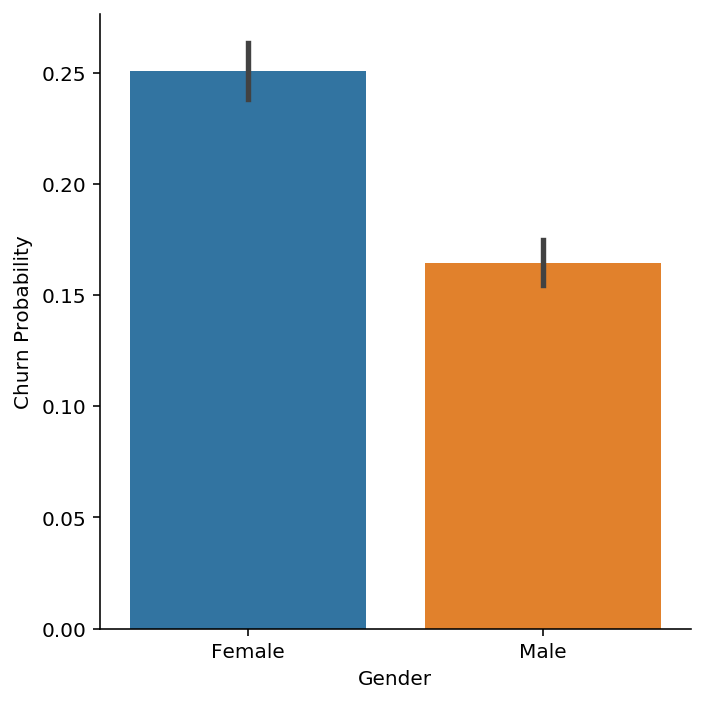

In [11]:
g= sns.factorplot(x = "Gender", y = "Exited", data = churn_data, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

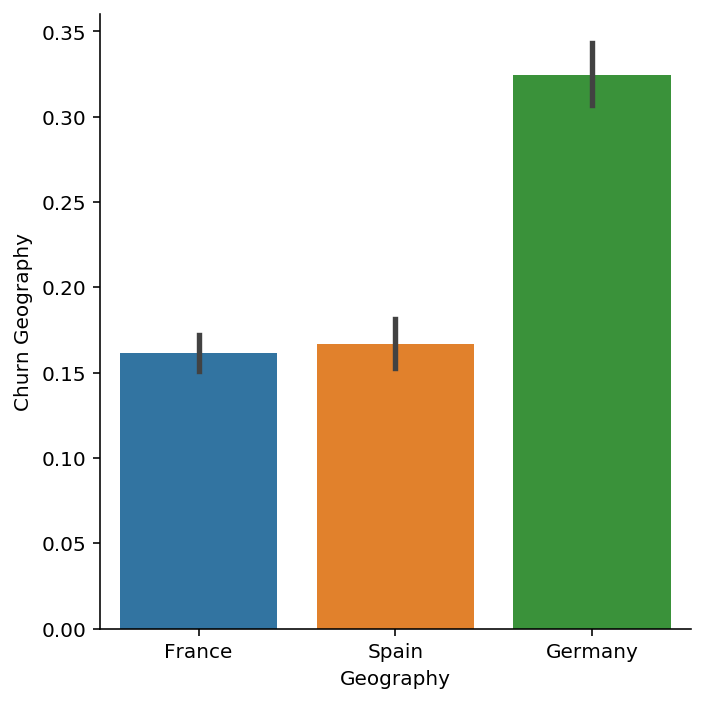

In [12]:
g= sns.factorplot(x = "Geography", y = "Exited", data = churn_data, kind = "bar", size = 5)
g.set_ylabels("Churn Geography")
plt.show()

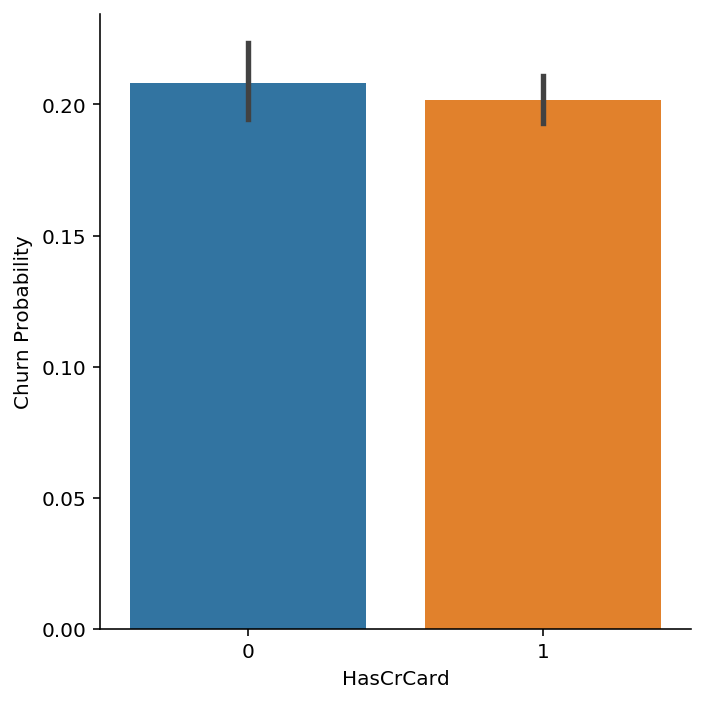

In [13]:
g= sns.factorplot(x = "HasCrCard", y = "Exited", data = churn_data, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

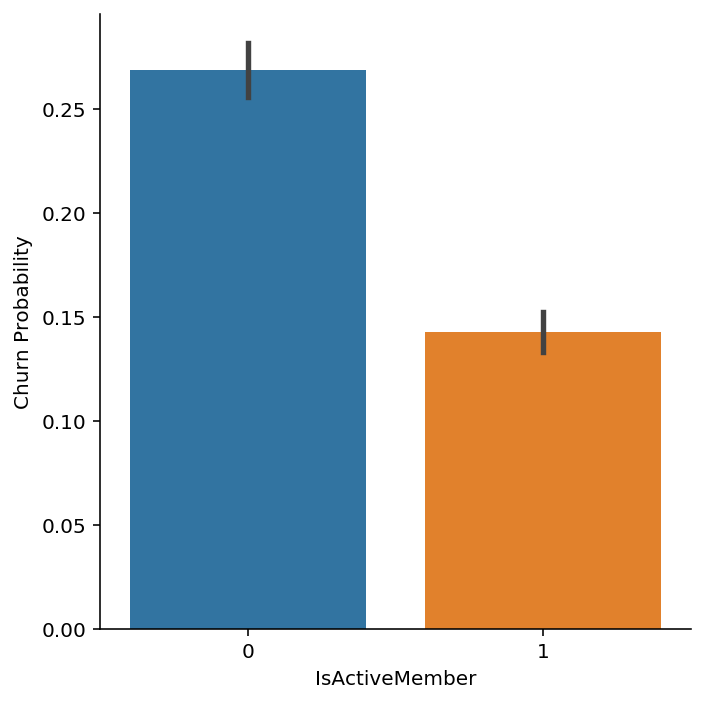

In [14]:
g= sns.factorplot(x = "IsActiveMember", y = "Exited", data = churn_data, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

#### Numeric Degiskenler

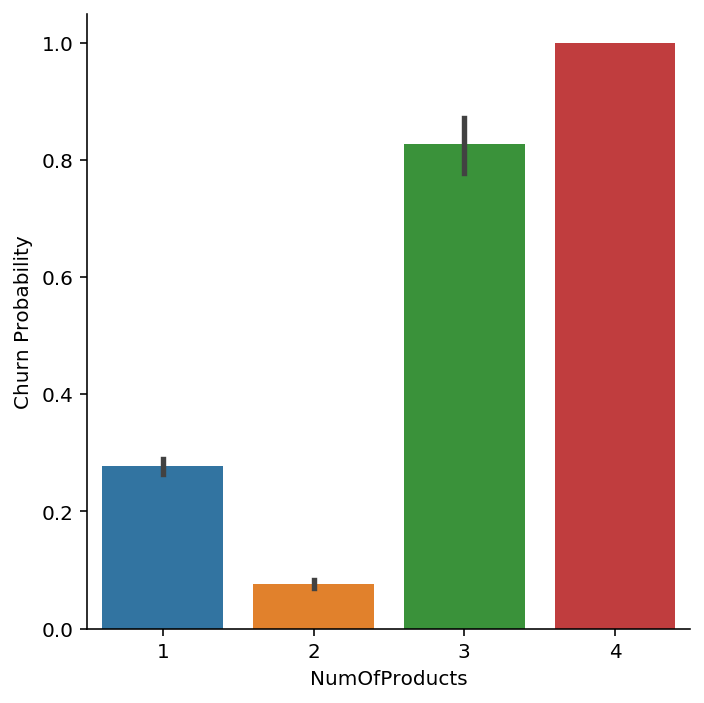

In [15]:
g= sns.factorplot(x = "NumOfProducts", y = "Exited", data = churn_data, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

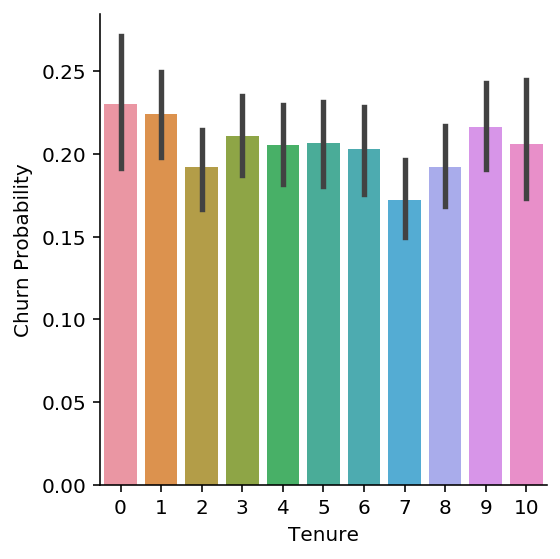

In [16]:
g= sns.factorplot(x = "Tenure", y = "Exited", data = churn_data, kind = "bar", size = 4)
g.set_ylabels("Churn Probability")
plt.show()

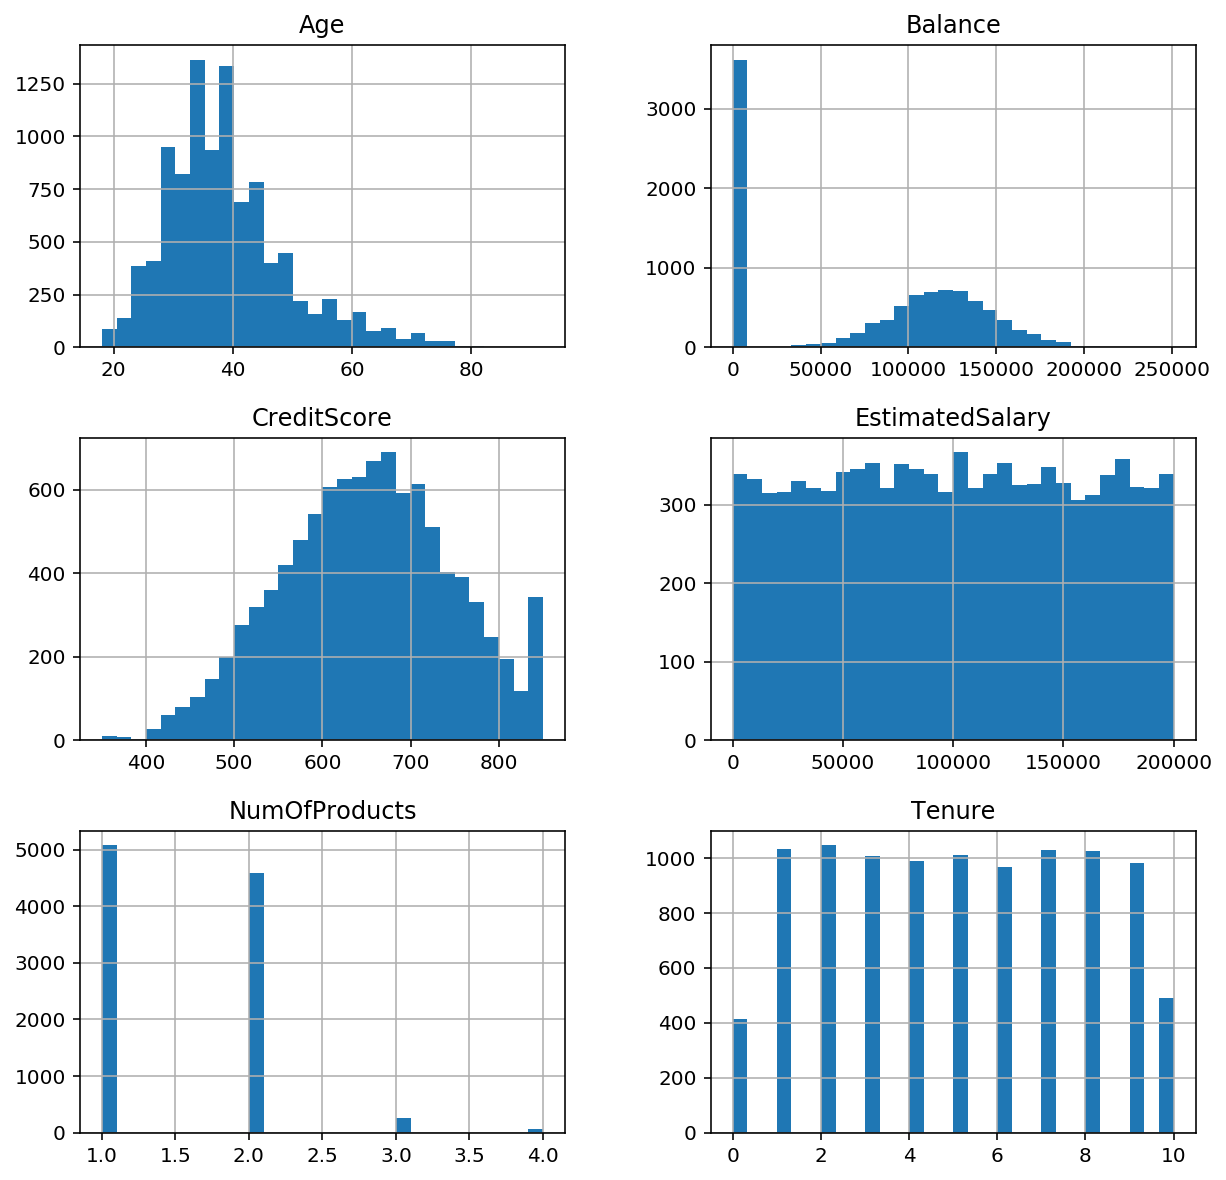

In [17]:
churn_data[numerical_features].hist(bins=30, figsize=(10, 10));

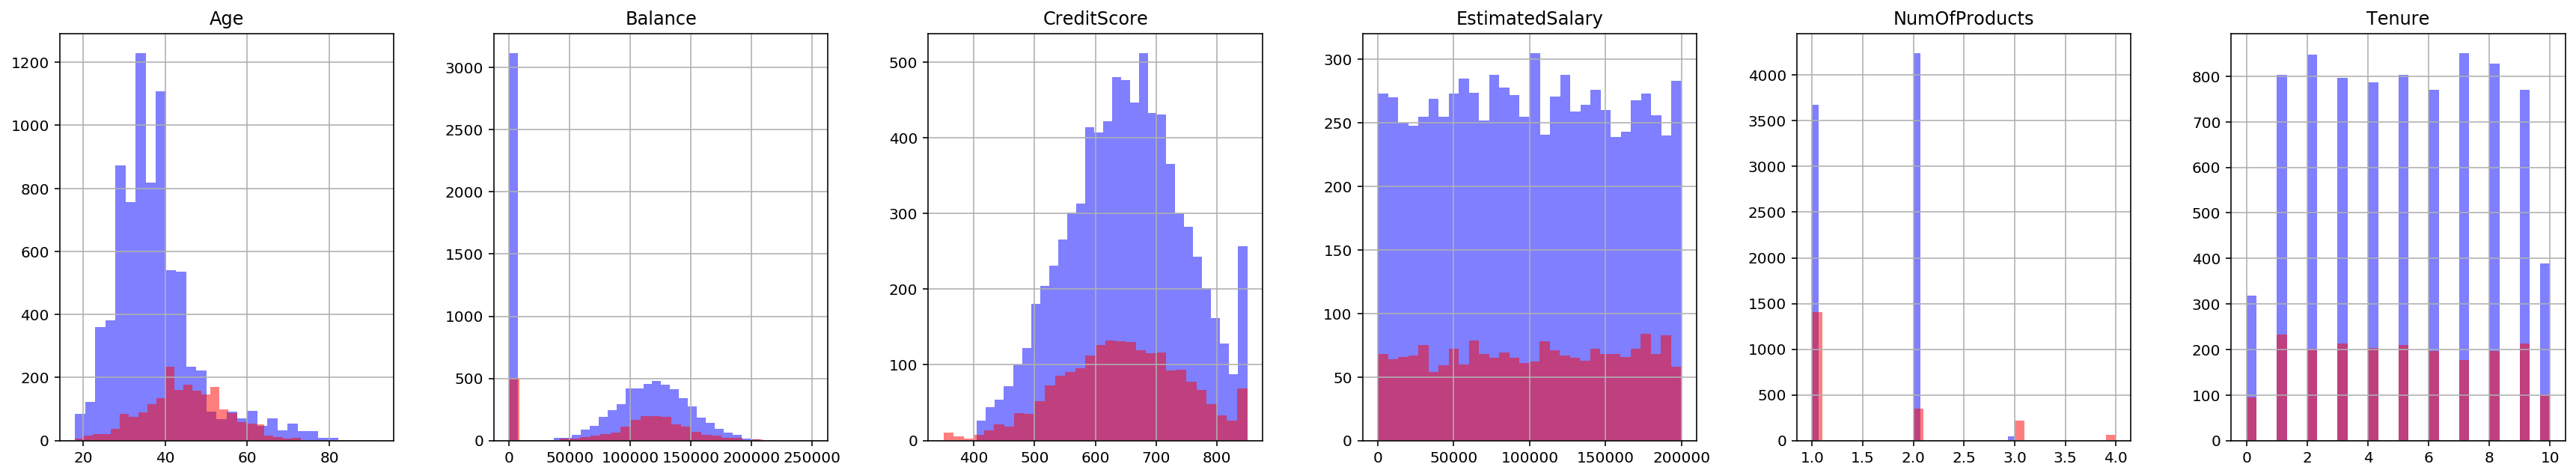

In [18]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))
churn_data[churn_data.Exited == 0][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax);
churn_data[churn_data.Exited == 1][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax);

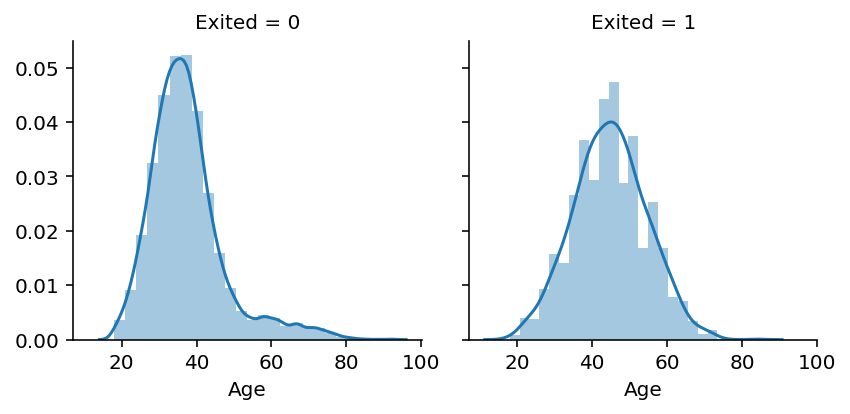

In [19]:
g= sns.FacetGrid(churn_data, col = "Exited")
g.map(sns.distplot, "Age", bins = 25)
plt.show()

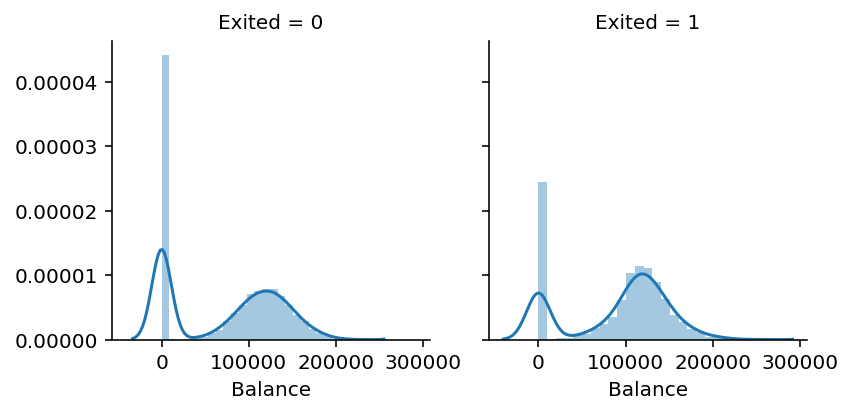

In [20]:
g= sns.FacetGrid(churn_data, col = "Exited")
g.map(sns.distplot, "Balance", bins = 25)
plt.show()

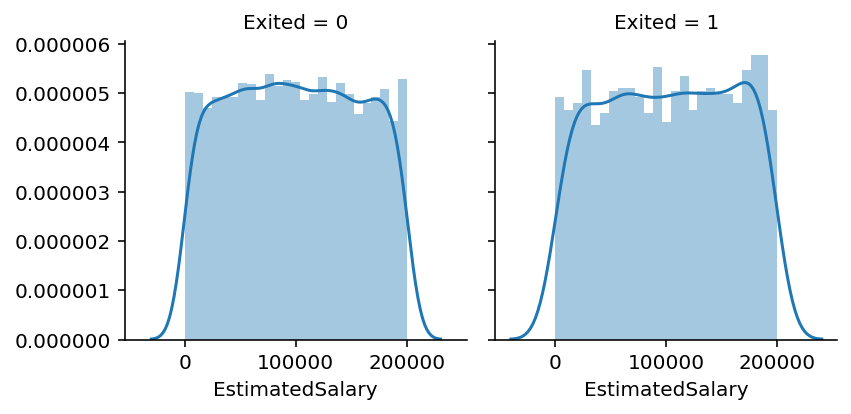

In [21]:
g= sns.FacetGrid(churn_data, col = "Exited")
g.map(sns.distplot, "EstimatedSalary", bins = 25)
plt.show()

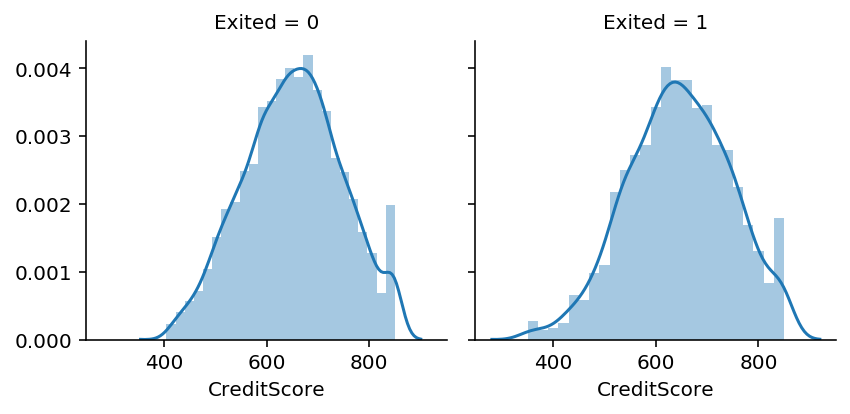

In [22]:
g= sns.FacetGrid(churn_data, col = "Exited")
g.map(sns.distplot, "CreditScore", bins = 25)
plt.show()

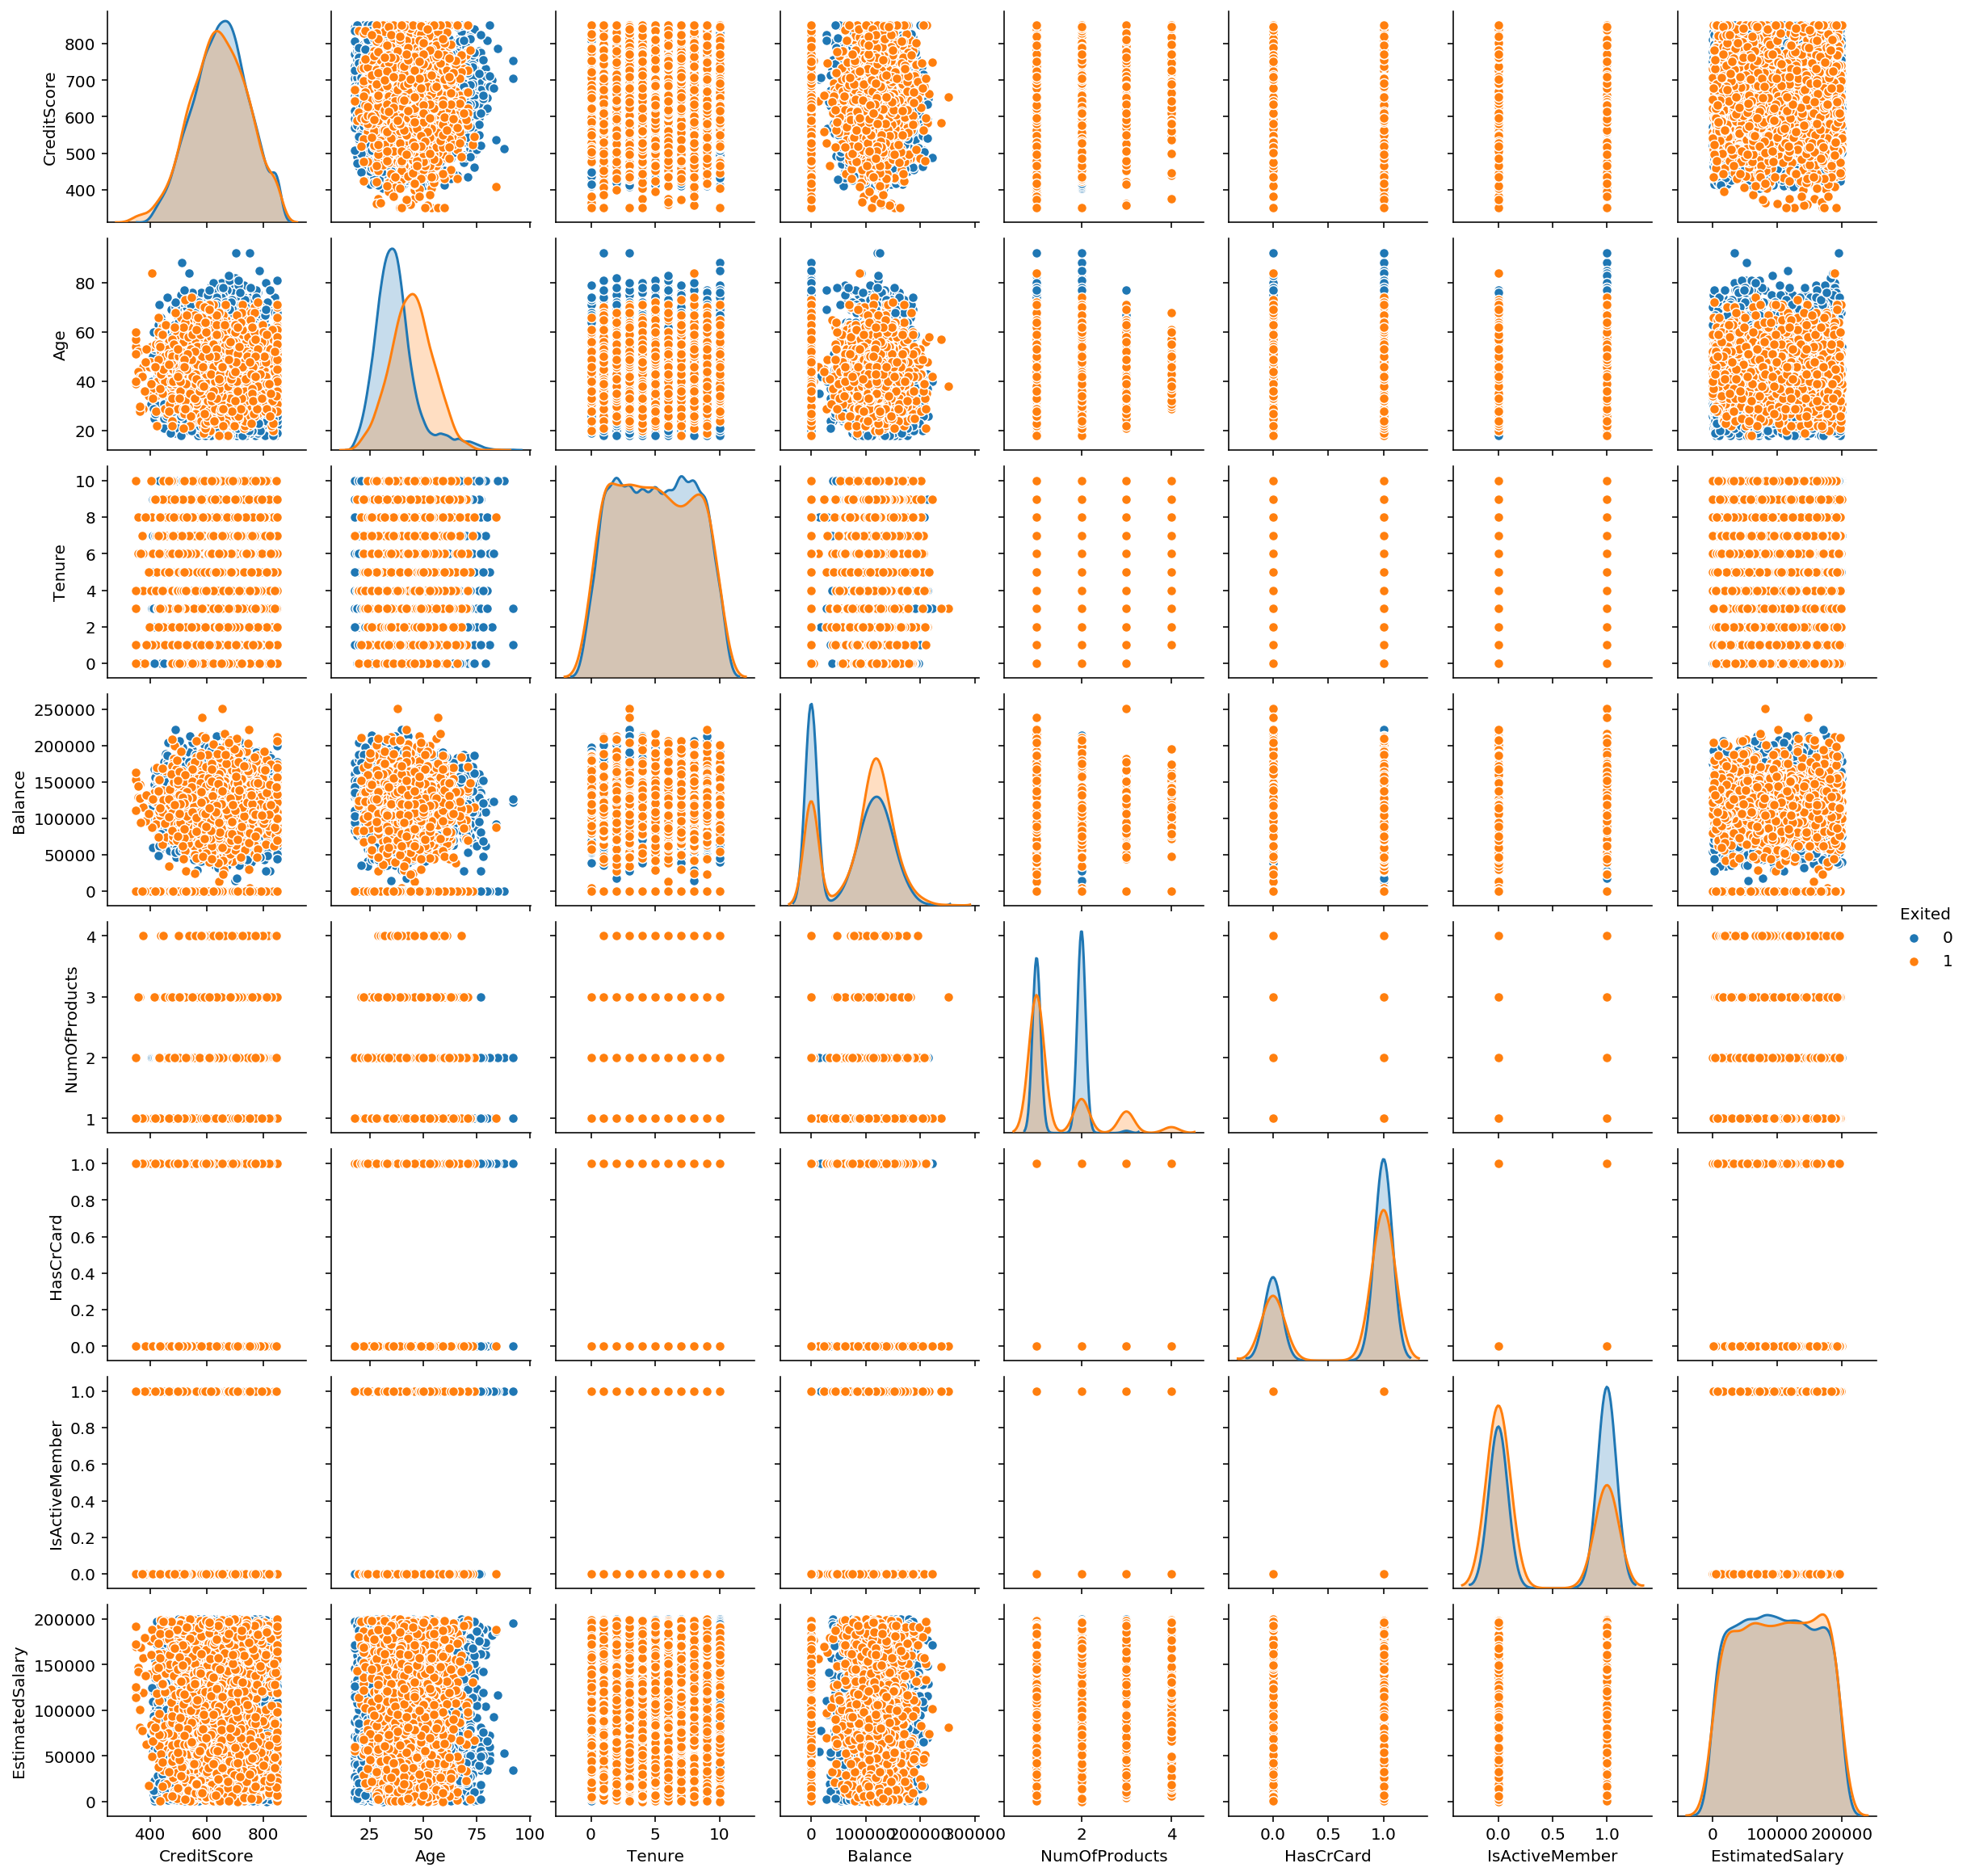

In [23]:
g = sns.pairplot(churn_data,hue = 'Exited',height=2,aspect=1)

## Feature Engineering

#### KATEGORIK degiskenler ile NUMERIC degiskenler arasinda AGGREGATION islemleri yaparak hem yeni feature uretebilir hem de datayi biraz daha derinlemesine inceleyebiliriz.

In [24]:
# once teker teker inceleyip en son tek bir fonksiyon ile sadelestirecegiz, 
# bu inceleme kisimlarini notebook'a son halini verirken cikartiriz

In [25]:
agg_list = {"CreditScore":["mean",'std','min','max'],
            "Age":["mean",'min', 'max'],
            "Tenure":["median",'std','min','max'],
            "Balance":["median",'std','min','max'],
            "EstimatedSalary":["mean",'min','max'] }
churn_data.groupby("Geography").agg(agg_list)

CreditScore                             Age         Tenure  \
                 mean        std  min  max       mean min max median   
Geography                                                              
France     649.668329  97.016799  350  850  38.511767  18  92      5   
Germany    651.453567  98.168937  350  850  39.771622  18  84      5   
Spain      651.333872  94.365051  350  850  38.890997  18  88      5   

                               Balance                                     \
                std min max     median           std       min        max   
Geography                                                                   
France     2.888475   0  10   62153.50  64133.565524      0.00  238387.56   
Germany    2.935154   0  10  119703.10  27022.006157  27288.43  214346.96   
Spain      2.856660   0  10   61710.44  64235.555208      0.00  250898.09   

          EstimatedSalary                     
                     mean     min        max  
Geography                                     
France       99899.180814   90.07  199929.17  
Germany     101113.435102   11.58  199970.74  
Spain        99440.572281  417.41  199992.48

In [26]:
df_Geography = churn_data.groupby("Geography").agg(agg_list)

In [27]:
df_Geography.head()

CreditScore                             Age         Tenure  \
                 mean        std  min  max       mean min max median   
Geography                                                              
France     649.668329  97.016799  350  850  38.511767  18  92      5   
Germany    651.453567  98.168937  350  850  39.771622  18  84      5   
Spain      651.333872  94.365051  350  850  38.890997  18  88      5   

                               Balance                                     \
                std min max     median           std       min        max   
Geography                                                                   
France     2.888475   0  10   62153.50  64133.565524      0.00  238387.56   
Germany    2.935154   0  10  119703.10  27022.006157  27288.43  214346.96   
Spain      2.856660   0  10   61710.44  64235.555208      0.00  250898.09   

          EstimatedSalary                     
                     mean     min        max  
Geography                                     
France       99899.180814   90.07  199929.17  
Germany     101113.435102   11.58  199970.74  
Spain        99440.572281  417.41  199992.48

In [28]:
df_Geography.columns # multiIndex bir dataframe olusuyor

MultiIndex([(    'CreditScore',   'mean'),
            (    'CreditScore',    'std'),
            (    'CreditScore',    'min'),
            (    'CreditScore',    'max'),
            (            'Age',   'mean'),
            (            'Age',    'min'),
            (            'Age',    'max'),
            (         'Tenure', 'median'),
            (         'Tenure',    'std'),
            (         'Tenure',    'min'),
            (         'Tenure',    'max'),
            (        'Balance', 'median'),
            (        'Balance',    'std'),
            (        'Balance',    'min'),
            (        'Balance',    'max'),
            ('EstimatedSalary',   'mean'),
            ('EstimatedSalary',    'min'),
            ('EstimatedSalary',    'max')],
           )

In [29]:
df_Geography.columns.tolist() # liste formatina ceviriyoruz

[('CreditScore', 'mean'),
 ('CreditScore', 'std'),
 ('CreditScore', 'min'),
 ('CreditScore', 'max'),
 ('Age', 'mean'),
 ('Age', 'min'),
 ('Age', 'max'),
 ('Tenure', 'median'),
 ('Tenure', 'std'),
 ('Tenure', 'min'),
 ('Tenure', 'max'),
 ('Balance', 'median'),
 ('Balance', 'std'),
 ('Balance', 'min'),
 ('Balance', 'max'),
 ('EstimatedSalary', 'mean'),
 ('EstimatedSalary', 'min'),
 ('EstimatedSalary', 'max')]

In [30]:
# multiIndex durumundan kurtulmak ve yeni degiskenlerin isimlerini duzenlemek istiyoruz, 

pd.Index([col[0] + "_" + col[1].upper() + '_Geography' for col in df_Geography.columns.tolist()])

Index(['CreditScore_MEAN_Geography', 'CreditScore_STD_Geography',
       'CreditScore_MIN_Geography', 'CreditScore_MAX_Geography',
       'Age_MEAN_Geography', 'Age_MIN_Geography', 'Age_MAX_Geography',
       'Tenure_MEDIAN_Geography', 'Tenure_STD_Geography',
       'Tenure_MIN_Geography', 'Tenure_MAX_Geography',
       'Balance_MEDIAN_Geography', 'Balance_STD_Geography',
       'Balance_MIN_Geography', 'Balance_MAX_Geography',
       'EstimatedSalary_MEAN_Geography', 'EstimatedSalary_MIN_Geography',
       'EstimatedSalary_MAX_Geography'],
      dtype='object')

In [31]:
df_Geography.columns = pd.Index([col[0] + "_" + col[1].upper() + '_Geography' for col in df_Geography.columns.tolist()])

In [32]:
df_Geography.head()

,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography
Geography,,,,,,,,,,,,,,,,,,
France,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.00,238387.56,99899.180814,90.07,199929.17
Germany,651.453567,98.168937,350,850,39.771622,18,84,5,2.935154,0,10,119703.10,27022.006157,27288.43,214346.96,101113.435102,11.58,199970.74
Spain,651.333872,94.365051,350,850,38.890997,18,88,5,2.856660,0,10,61710.44,64235.555208,0.00,250898.09,99440.572281,417.41,199992.48


In [33]:
# reset_index() indexin sifirdan baslatilmasi

df_Geography.reset_index().head()

,Geography,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography
0,France,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.00,238387.56,99899.180814,90.07,199929.17
1,Germany,651.453567,98.168937,350,850,39.771622,18,84,5,2.935154,0,10,119703.10,27022.006157,27288.43,214346.96,101113.435102,11.58,199970.74
2,Spain,651.333872,94.365051,350,850,38.890997,18,88,5,2.856660,0,10,61710.44,64235.555208,0.00,250898.09,99440.572281,417.41,199992.48


In [34]:
agg_list = {"CreditScore":["mean",'std','min','max'],
            "Age":["mean",'min', 'max'],
            "Tenure":["median",'std','min','max'],
            "Balance":["median",'std','min','max'],
            "EstimatedSalary":["mean",'min','max'] }
churn_data.groupby("Gender").agg(agg_list)

CreditScore                             Age         Tenure            \
              mean        std  min  max       mean min max median       std   
Gender                                                                        
Female  650.831389  96.787350  350  850  39.238389  18  85      5  2.910252   
Male    650.276892  96.549706  350  850  38.658237  18  92      5  2.876726   

                 Balance                               EstimatedSalary         \
       min max    median           std  min        max            mean    min   
Gender                                                                          
Female   0  10  96147.55  62102.467293  0.0  238387.56   100601.541382  91.75   
Male     0  10  98064.97  62639.251138  0.0  250898.09    99664.576931  11.58   

                   
              max  
Gender             
Female  199992.48  
Male    199953.33

In [35]:
agg_list = {"CreditScore":["mean",'std','min','max'],
            "Age":["mean",'min', 'max'],
            "Tenure":["median",'std','min','max'],
            "Balance":["median",'std','min','max'],
            "EstimatedSalary":["mean",'min','max'] }
churn_data.groupby("NumOfProducts").agg(agg_list)

CreditScore                              Age         Tenure  \
                     mean         std  min  max       mean min max median   
NumOfProducts                                                               
1              649.120968   97.203710  350  850  39.673092  18  92      5   
2              652.188671   96.066831  350  850  37.753595  18  92      5   
3              648.105263   95.190396  358  850  43.195489  21  77      5   
4              653.583333  101.265600  376  850  45.683333  29  68      5   

                                    Balance                                \
                    std min max      median           std  min        max   
NumOfProducts                                                               
1              2.914269   0  10  111886.035  53234.092790  0.0  238387.56   
2              2.867741   0  10       0.000  62644.474506  0.0  214346.96   
3              2.879332   0  10   95973.935  62924.623833  0.0  250898.09   
4              2.947564   1  10  116808.195  57507.383750  0.0  195238.29   

              EstimatedSalary                      
                         mean      min        max  
NumOfProducts                                      
1                99487.256851    11.58  199970.74  
2               100452.012821    90.07  199992.48  
3               104318.130564  3440.47  199357.24  
4               104763.723333  5669.31  198874.52

In [36]:
agg_list = {"CreditScore":["mean",'std','min','max'],
            "Age":["mean",'min', 'max'],
            "Tenure":["median",'std','min','max'],
            "Balance":["median",'std','min','max'],
            "EstimatedSalary":["mean",'min','max'] }
churn_data.groupby("HasCrCard").agg(agg_list)

CreditScore                             Age         Tenure  \
                 mean        std  min  max       mean min max median   
HasCrCard                                                              
0          651.345331  96.637830  350  850  39.112054  18  92      5   
1          650.187952  96.664563  350  850  38.842381  18  92      5   

                              Balance                                \
                std min max    median           std  min        max   
HasCrCard                                                             
0          2.926120   0  10  97990.49  61951.756426  0.0  250898.09   
1          2.877044   0  10  96877.21  62577.134010  0.0  221532.80   

          EstimatedSalary                    
                     mean    min        max  
HasCrCard                                    
0           100974.397711  90.07  199992.48  
1            99721.161949  11.58  199970.74

In [37]:
agg_list = {"CreditScore":["mean",'std','min','max'],
            "Age":["mean",'min', 'max'],
            "Tenure":["median",'std','min','max'],
            "Balance":["median",'std','min','max'],
            "EstimatedSalary":["mean",'min','max'] }
churn_data.groupby("IsActiveMember").agg(agg_list)

CreditScore                             Age         Tenure  \
                      mean        std  min  max       mean min max median   
IsActiveMember                                                              
0               647.973603  97.725193  350  850  37.997938  18  84      5   
1               652.934188  95.580356  350  850  39.791497  18  92      5   

                                   Balance                                \
                     std min max    median           std  min        max   
IsActiveMember                                                             
0               2.883465   0  10  98263.46  62545.195018  0.0  222267.63   
1               2.898377   0  10  96166.88  62257.859389  0.0  250898.09   

               EstimatedSalary                    
                          mean    min        max  
IsActiveMember                                    
0                100767.203854  91.75  199992.48  
1                 99452.965894  11.58  199953.33

In [38]:
# Aggregation islemlerinin hepsini tek bir fonksiyon altinda topluyoruz

def aggregation_to_categorical(df):
    
    agg_list = {"CreditScore":["mean",'std','min','max'],
                "Age":["mean",'min', 'max'],
                "Tenure":["median",'std','min','max'],
                "Balance":["median",'std','min','max'],
                "EstimatedSalary":["mean",'min','max'] }
    
    df_Geography = df.groupby("Geography").agg(agg_list)
    df_Geography.columns = pd.Index([col[0] + "_" + col[1].upper() + '_Geography' for col in df_Geography.columns.tolist()])
    df_Geography=df_Geography.reset_index()

    df_Gender = df.groupby("Gender").agg(agg_list)
    df_Gender.columns = pd.Index([col[0] + "_" + col[1].upper() + '_Gender' for col in df_Gender.columns.tolist()])
    df_Gender=df_Gender.reset_index()
 

    df_HasCrCard = df.groupby("HasCrCard").agg(agg_list)
    df_HasCrCard.columns = pd.Index([col[0] + "_" + col[1].upper() + '_HasCrCard' for col in df_HasCrCard.columns.tolist()])
    df_HasCrCard=df_HasCrCard.reset_index()
    
    df_IsActiveMember = df.groupby("IsActiveMember").agg(agg_list)
    df_IsActiveMember.columns = pd.Index([col[0] + "_" + col[1].upper() + '_IsActiveMember' for col in df_IsActiveMember.columns.tolist()])
    df_IsActiveMember=df_IsActiveMember.reset_index()

    df = df.merge(df_Geography, how='left', on= 'Geography')
    df = df.merge(df_Gender, how='left', on= 'Gender')
    df = df.merge(df_HasCrCard, how='left', on= 'HasCrCard')
    df = df.merge(df_IsActiveMember, how='left', on= 'IsActiveMember')
    
    return df

In [39]:
# Aggregation fonksiyonunu çalıştıralım ve datasetine uygulayıp bunu churn_data değişkenine atayalım
churn_data = aggregation_to_categorical(churn_data)

In [40]:
churn_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography,CreditScore_MEAN_Gender,CreditScore_STD_Gender,CreditScore_MIN_Gender,CreditScore_MAX_Gender,Age_MEAN_Gender,Age_MIN_Gender,Age_MAX_Gender,Tenure_MEDIAN_Gender,Tenure_STD_Gender,Tenure_MIN_Gender,Tenure_MAX_Gender,Balance_MEDIAN_Gender,Balance_STD_Gender,Balance_MIN_Gender,Balance_MAX_Gender,EstimatedSalary_MEAN_Gender,EstimatedSalary_MIN_Gender,EstimatedSalary_MAX_Gender,CreditScore_MEAN_HasCrCard,CreditScore_STD_HasCrCard,CreditScore_MIN_HasCrCard,CreditScore_MAX_HasCrCard,Age_MEAN_HasCrCard,Age_MIN_HasCrCard,Age_MAX_HasCrCard,Tenure_MEDIAN_HasCrCard,Tenure_STD_HasCrCard,Tenure_MIN_HasCrCard,Tenure_MAX_HasCrCard,Balance_MEDIAN_HasCrCard,Balance_STD_HasCrCard,Balance_MIN_HasCrCard,Balance_MAX_HasCrCard,EstimatedSalary_MEAN_HasCrCard,EstimatedSalary_MIN_HasCrCard,EstimatedSalary_MAX_HasCrCard,CreditScore_MEAN_IsActiveMember,CreditScore_STD_IsActiveMember,CreditScore_MIN_IsActiveMember,CreditScore_MAX_IsActiveMember,Age_MEAN_IsActiveMember,Age_MIN_IsActiveMember,Age_MAX_IsActiveMember,Tenure_MEDIAN_IsActiveMember,Tenure_STD_IsActiveMember,Tenure_MIN_IsActiveMember,Tenure_MAX_IsActiveMember,Balance_MEDIAN_IsActiveMember,Balance_STD_IsActiveMember,Balance_MIN_IsActiveMember,Balance_MAX_IsActiveMember,EstimatedSalary_MEAN_IsActiveMember,EstimatedSalary_MIN_IsActiveMember,EstimatedSalary_MAX_IsActiveMember
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.664563,350,850,38.842381,18,92,5,2.877044,0,10,96877.21,62577.134010,0.0,221532.80,99721.161949,11.58,199970.74,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,651.333872,94.365051,350,850,38.890997,18,88,5,2.856660,0,10,61710.44,64235.555208,0.0,250898.09,99440.572281,417.41,199992.48,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,651.345331,96.637830,350,850,39.112054,18,92,5,2.926120,0,10,97990.49,61951.756426,0.0,250898.09,100974.397711,90.07,199992.48,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.664563,350,850,38.842381,18,92,5,2.877044,0,10,96877.21,62577.134010,0.0,221532.80,99721.161949,11.58,199970.74,647.973603,97.725193,350,850,37.997938,18,84,5,2.883465,0,10,98263.46,62545.195018,0.0,222267.63,100767.203854,91.75,199992.48
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,651.345331,96.637830,350,850,39.112054,18,92,5,2.926120,0,10,97990.49,61951.756426,0.0,250898.09,100974.397711,90.07,199992.48,647.973603,97.725193,350,850,37.997938,18,84

### Yeni Feature uretmek, ornek notebooklar'a bakilarak ve kendi kisisel tercihinizle bunlara karar verebilirsiniz, 

- Surname : Soy isim
- CreditScore : Kredi skoru
- Geography : Ülke (Germany/France/Spain)
- Gender : Cinsiyet (Female/Male)
- Age : Yaş
- Tenure : Kaç yıllık müşteri
- Balance : Bakiye
- NumOfProducts : Kullanılan banka ürünü
- HasCrCard : Kredi kartı durumu (0=No,1=Yes)
- IsActiveMember : Aktif üyelik durumu (0=No,1=Yes)
- EstimatedSalary : Tahmini maaş
- Exited : Terk mi değil mi? (0=No,1=Yes)

In [41]:
# Burada yapilanlar ornek calismalardan derlenmistir, mantikli olan olmayan ayrimi yapilmadan 
# yeni feature uretme noktasinda degisik alternatifler uzerinde durulabilir

def new_features(df):
    
    df['HasCrCard_2'] = df['HasCrCard'].replace(to_replace = 0, value = -1)
    df['IsActiveMember_2'] = df['IsActiveMember'].replace(to_replace = 0, value = -1)
    df['Age_Balance_Ratio'] = df.Balance / df.Age
    df['Age_Cross_NumOfProducts'] = df.Age * df.NumOfProducts
    df['Score_Age_Ratio'] = df.CreditScore / df.Age
    df['Age_Salary_Ratio'] = df.EstimatedSalary / df.Age
    df['Balance_Salary_Ratio'] = df.Balance / df.EstimatedSalary
    df['Score_Balance_Ratio'] = df.Balance / df.CreditScore
    df['Score_Salary_Ratio'] = df.CreditScore / df.EstimatedSalary
    df['Score_HasCrCard_2'] = df.CreditScore * df.HasCrCard_2
    df['Score_Cross_NumOfProducts'] = df.CreditScore * df.NumOfProducts
    df['Balance_NumOfProducts_Ratio'] = df.CreditScore / df.NumOfProducts
    df['Age_Cross_HasCrCard_2'] = df.Age * df.HasCrCard_2
    df['Balance_Cross_HasCrCard_2'] = df.Balance * df.HasCrCard_2
    df['Age_Cross_IsActiveMember_2'] = df.Age * df.IsActiveMember_2
    df['Score_Cross_IsActiveMember_2'] = df.CreditScore * df.IsActiveMember_2
    df['Balance_Cross_IsActiveMember_2'] = df.Balance * df.IsActiveMember_2
    df['Tenure_Cross_Balance'] = df.Balance * df.Tenure
    df['Tenure_Cross_NumOfProducts'] = df.Tenure * df.NumOfProducts
    df['Score_Cross_Tenure'] = df.Tenure * df.CreditScore
    df['Tenure_Salary_Ratio'] = df.Tenure / df.EstimatedSalary
    
    df= df.drop(['IsActiveMember_2', 'HasCrCard_2'], axis=1)    

    return df

In [42]:
churn_data = new_features(churn_data)

In [43]:
# Data boyutu
churn_data.shape

(10000, 102)

In [44]:
churn_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography,CreditScore_MEAN_Gender,CreditScore_STD_Gender,CreditScore_MIN_Gender,CreditScore_MAX_Gender,Age_MEAN_Gender,Age_MIN_Gender,Age_MAX_Gender,Tenure_MEDIAN_Gender,Tenure_STD_Gender,Tenure_MIN_Gender,Tenure_MAX_Gender,Balance_MEDIAN_Gender,Balance_STD_Gender,Balance_MIN_Gender,Balance_MAX_Gender,EstimatedSalary_MEAN_Gender,EstimatedSalary_MIN_Gender,EstimatedSalary_MAX_Gender,CreditScore_MEAN_HasCrCard,CreditScore_STD_HasCrCard,CreditScore_MIN_HasCrCard,CreditScore_MAX_HasCrCard,Age_MEAN_HasCrCard,Age_MIN_HasCrCard,Age_MAX_HasCrCard,Tenure_MEDIAN_HasCrCard,Tenure_STD_HasCrCard,Tenure_MIN_HasCrCard,Tenure_MAX_HasCrCard,Balance_MEDIAN_HasCrCard,Balance_STD_HasCrCard,Balance_MIN_HasCrCard,Balance_MAX_HasCrCard,EstimatedSalary_MEAN_HasCrCard,EstimatedSalary_MIN_HasCrCard,EstimatedSalary_MAX_HasCrCard,CreditScore_MEAN_IsActiveMember,CreditScore_STD_IsActiveMember,CreditScore_MIN_IsActiveMember,CreditScore_MAX_IsActiveMember,Age_MEAN_IsActiveMember,Age_MIN_IsActiveMember,Age_MAX_IsActiveMember,Tenure_MEDIAN_IsActiveMember,Tenure_STD_IsActiveMember,Tenure_MIN_IsActiveMember,Tenure_MAX_IsActiveMember,Balance_MEDIAN_IsActiveMember,Balance_STD_IsActiveMember,Balance_MIN_IsActiveMember,Balance_MAX_IsActiveMember,EstimatedSalary_MEAN_IsActiveMember,EstimatedSalary_MIN_IsActiveMember,EstimatedSalary_MAX_IsActiveMember,Age_Balance_Ratio,Age_Cross_NumOfProducts,Score_Age_Ratio,Age_Salary_Ratio,Balance_Salary_Ratio,Score_Balance_Ratio,Score_Salary_Ratio,Score_HasCrCard_2,Score_Cross_NumOfProducts,Balance_NumOfProducts_Ratio,Age_Cross_HasCrCard_2,Balance_Cross_HasCrCard_2,Age_Cross_IsActiveMember_2,Score_Cross_IsActiveMember_2,Balance_Cross_IsActiveMember_2,Tenure_Cross_Balance,Tenure_Cross_NumOfProducts,Score_Cross_Tenure,Tenure_Salary_Ratio
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.664563,350,850,38.842381,18,92,5,2.877044,0,10,96877.21,62577.134010,0.0,221532.80,99721.161949,11.58,199970.74,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33,0.000000,42,14.738095,2413.068571,0.000000,0.000000,0.006108,619,619,619.000000,42,0.00,42,619,0.00,0.00,2,1238,0.000020
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,651.333872,94.365051,350,850,38.890997,18,88,5,2.856660,0,10,61710.44,64235.555208,0.0,250898.09,99440.572281,417.41,199992.48,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,651.345331,96.637830,350,850,39.112054,18,92,5,2.926120,0,10,97990.49,61951.756426,0.0,250898.09,100974.397711,90.07,199992.48,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33,2044.094146,41,14.829268,2744.940976,0.744677,137.841875,0.005402,-608,608,608.000000,-41,-83807.86,41,608,83807.86,83807.86,1,608,0.000009
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.664563,350,850,38.8

## Data Preprocessing

In [45]:
# 3  farklı tür var ondan one_hot_encoding uygukuyoruz.
churn_data.Geography.value_counts().count()

3

In [46]:
# label encoder formatında olduğundan aynen kalıyor
churn_data.HasCrCard.value_counts().count()

2

In [47]:
# label encoder formatında olduğundan aynen kalıyor
churn_data.IsActiveMember.value_counts().count()

2

### One Hot Encoding and Label Encoder



In [48]:
# Gender degiskeni'ne label encoder 

from sklearn.preprocessing import LabelEncoder
  
label_encoder = LabelEncoder() 
  
churn_data["Gender"] = label_encoder.fit_transform(churn_data["Gender"])

In [49]:
# 1.yol, fonksiyon yazarak bu sekilde yapabiliriz

def encoding(df):
    
    df = pd.get_dummies(df, columns = ["Geography"], prefix = ["Geography"])
     
    return df

In [50]:
churn_data = encoding(churn_data)

In [51]:
# 2.yol tek bir kod ile de yazabiliriz

"""
churn_data = pd.get_dummies(churn_data,
                            prefix_sep='_', 
                            columns=["Geography"],
                            drop_first=True,
                            dtype=int)
"""

'\nchurn_data = pd.get_dummies(churn_data,\n                            prefix_sep=\'_\', \n                            columns=["Geography"],\n                            drop_first=True,\n                            dtype=int)\n'

In [52]:
# Gender degiskeni'ne label encoder icin alternatif bir kod

# churn_data["Gender"]=churn_data["Gender"].map(lambda x: 0 if x=='Female' else 1)

In [53]:
churn_data.shape

(10000, 104)

In [54]:
# Datanın son halini görelim.
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography,CreditScore_MEAN_Gender,CreditScore_STD_Gender,CreditScore_MIN_Gender,CreditScore_MAX_Gender,Age_MEAN_Gender,Age_MIN_Gender,Age_MAX_Gender,Tenure_MEDIAN_Gender,Tenure_STD_Gender,Tenure_MIN_Gender,Tenure_MAX_Gender,Balance_MEDIAN_Gender,Balance_STD_Gender,Balance_MIN_Gender,Balance_MAX_Gender,EstimatedSalary_MEAN_Gender,EstimatedSalary_MIN_Gender,EstimatedSalary_MAX_Gender,CreditScore_MEAN_HasCrCard,CreditScore_STD_HasCrCard,CreditScore_MIN_HasCrCard,CreditScore_MAX_HasCrCard,Age_MEAN_HasCrCard,Age_MIN_HasCrCard,Age_MAX_HasCrCard,Tenure_MEDIAN_HasCrCard,Tenure_STD_HasCrCard,Tenure_MIN_HasCrCard,Tenure_MAX_HasCrCard,Balance_MEDIAN_HasCrCard,Balance_STD_HasCrCard,Balance_MIN_HasCrCard,Balance_MAX_HasCrCard,EstimatedSalary_MEAN_HasCrCard,EstimatedSalary_MIN_HasCrCard,EstimatedSalary_MAX_HasCrCard,CreditScore_MEAN_IsActiveMember,CreditScore_STD_IsActiveMember,CreditScore_MIN_IsActiveMember,CreditScore_MAX_IsActiveMember,Age_MEAN_IsActiveMember,Age_MIN_IsActiveMember,Age_MAX_IsActiveMember,Tenure_MEDIAN_IsActiveMember,Tenure_STD_IsActiveMember,Tenure_MIN_IsActiveMember,Tenure_MAX_IsActiveMember,Balance_MEDIAN_IsActiveMember,Balance_STD_IsActiveMember,Balance_MIN_IsActiveMember,Balance_MAX_IsActiveMember,EstimatedSalary_MEAN_IsActiveMember,EstimatedSalary_MIN_IsActiveMember,EstimatedSalary_MAX_IsActiveMember,Age_Balance_Ratio,Age_Cross_NumOfProducts,Score_Age_Ratio,Age_Salary_Ratio,Balance_Salary_Ratio,Score_Balance_Ratio,Score_Salary_Ratio,Score_HasCrCard_2,Score_Cross_NumOfProducts,Balance_NumOfProducts_Ratio,Age_Cross_HasCrCard_2,Balance_Cross_HasCrCard_2,Age_Cross_IsActiveMember_2,Score_Cross_IsActiveMember_2,Balance_Cross_IsActiveMember_2,Tenure_Cross_Balance,Tenure_Cross_NumOfProducts,Score_Cross_Tenure,Tenure_Salary_Ratio,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.664563,350,850,38.842381,18,92,5,2.877044,0,10,96877.21,62577.134010,0.0,221532.80,99721.161949,11.58,199970.74,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33,0.000000,42,14.738095,2413.068571,0.000000,0.000000,0.006108,619,619,619.000000,42,0.00,42,619,0.00,0.00,2,1238,0.000020,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,651.333872,94.365051,350,850,38.890997,18,88,5,2.856660,0,10,61710.44,64235.555208,0.0,250898.09,99440.572281,417.41,199992.48,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,651.345331,96.637830,350,850,39.112054,18,92,5,2.926120,0,10,97990.49,61951.756426,0.0,250898.09,100974.397711,90.07,199992.48,652.934188,95.580356,350,850,39.791497,18,92,5,2.898377,0,10,96166.88,62257.859389,0.0,250898.09,99452.965894,11.58,199953.33,2044.094146,41,14.829268,2744.940976,0.744677,137.841875,0.005402,-608,608,608.000000,-41,-83807.86,41,608,83807.86,83807.86,1,608,0.000009,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,649.668329,97.016799,350,850,38.511767,18,92,5,2.888475,0,10,62153.50,64133.565524,0.0,238387.56,99899.180814,90.07,199929.17,650.831389,96.78735,350,850,39.238389,18,85,5,2.910252,0,10,96147.55,62102.467293,0.0,238387.56,100601.541382,91.75,199992.48,650.187952,96.6

In [55]:
X_churn_data = churn_data.drop("Exited",axis=1)
y = churn_data["Exited"]

In [56]:

yedek_X_churn_data = X_churn_data.copy()

## Alternatif Scaler yontemleri
https://stats.stackexchange.com/questions/463690/multiple-regression-with-mixed-continuous-categorical-variables-dummy-coding-s

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

### Bütün dataya scaling uygulanması


In [57]:
# Bütün data scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

data_scaled1 = scaler.fit_transform(X_churn_data)

In [58]:
# Scaled datayı pandas dataframe e cevirme
data_scaled_dataframe = pd.DataFrame(data=data_scaled1, columns=X_churn_data.columns)

In [59]:
data_scaled_dataframe.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditScore_MEAN_Geography,CreditScore_STD_Geography,CreditScore_MIN_Geography,CreditScore_MAX_Geography,Age_MEAN_Geography,Age_MIN_Geography,Age_MAX_Geography,Tenure_MEDIAN_Geography,Tenure_STD_Geography,Tenure_MIN_Geography,Tenure_MAX_Geography,Balance_MEDIAN_Geography,Balance_STD_Geography,Balance_MIN_Geography,Balance_MAX_Geography,EstimatedSalary_MEAN_Geography,EstimatedSalary_MIN_Geography,EstimatedSalary_MAX_Geography,CreditScore_MEAN_Gender,CreditScore_STD_Gender,CreditScore_MIN_Gender,CreditScore_MAX_Gender,Age_MEAN_Gender,Age_MIN_Gender,Age_MAX_Gender,Tenure_MEDIAN_Gender,Tenure_STD_Gender,Tenure_MIN_Gender,Tenure_MAX_Gender,Balance_MEDIAN_Gender,Balance_STD_Gender,Balance_MIN_Gender,Balance_MAX_Gender,EstimatedSalary_MEAN_Gender,EstimatedSalary_MIN_Gender,EstimatedSalary_MAX_Gender,CreditScore_MEAN_HasCrCard,CreditScore_STD_HasCrCard,CreditScore_MIN_HasCrCard,CreditScore_MAX_HasCrCard,Age_MEAN_HasCrCard,Age_MIN_HasCrCard,Age_MAX_HasCrCard,Tenure_MEDIAN_HasCrCard,Tenure_STD_HasCrCard,Tenure_MIN_HasCrCard,Tenure_MAX_HasCrCard,Balance_MEDIAN_HasCrCard,Balance_STD_HasCrCard,Balance_MIN_HasCrCard,Balance_MAX_HasCrCard,EstimatedSalary_MEAN_HasCrCard,EstimatedSalary_MIN_HasCrCard,EstimatedSalary_MAX_HasCrCard,CreditScore_MEAN_IsActiveMember,CreditScore_STD_IsActiveMember,CreditScore_MIN_IsActiveMember,CreditScore_MAX_IsActiveMember,Age_MEAN_IsActiveMember,Age_MIN_IsActiveMember,Age_MAX_IsActiveMember,Tenure_MEDIAN_IsActiveMember,Tenure_STD_IsActiveMember,Tenure_MIN_IsActiveMember,Tenure_MAX_IsActiveMember,Balance_MEDIAN_IsActiveMember,Balance_STD_IsActiveMember,Balance_MIN_IsActiveMember,Balance_MAX_IsActiveMember,EstimatedSalary_MEAN_IsActiveMember,EstimatedSalary_MIN_IsActiveMember,EstimatedSalary_MAX_IsActiveMember,Age_Balance_Ratio,Age_Cross_NumOfProducts,Score_Age_Ratio,Age_Salary_Ratio,Balance_Salary_Ratio,Score_Balance_Ratio,Score_Salary_Ratio,Score_HasCrCard_2,Score_Cross_NumOfProducts,Balance_NumOfProducts_Ratio,Age_Cross_HasCrCard_2,Balance_Cross_HasCrCard_2,Age_Cross_IsActiveMember_2,Score_Cross_IsActiveMember_2,Balance_Cross_IsActiveMember_2,Tenure_Cross_Balance,Tenure_Cross_NumOfProducts,Score_Cross_Tenure,Tenure_Salary_Ratio,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0.0,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,0.000000,0.697115,0.0,0.0,0.000000,0.0,1.0,0.0,0.40531,0.0,0.0,0.00764,0.997259,0.0,0.657725,0.274146,0.193406,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.094488,0.235083,0.220105,0.000000,0.000000,0.000070,0.864118,0.088197,0.694444,0.728261,0.531079,0.715909,0.864118,0.469746,0.000000,0.050,0.145647,0.000057,1.0,0.0,0.0
1,0.516,0.0,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.932953,0.000000,0.0,0.0,0.301011,0.0,0.5,0.0,0.00000,0.0,0.0,0.00000,1.000000,0.0,1.000000,0.000000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.200183,0.090551,0.237252,0.250380,0.000070,0.296559,0.000058,0.142353,0.084590,0.679894,0.277174,0.353682,0.710227,0.857647,0.646867,0.041753,0.025,0.071529,0.000026,0.0,0.0,1.0
2,0.304,0.0,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,0.000000,0.697115,0.0,0.0,0.000000,0.0,1.0,0.0,0.40531,0.0,0.0,0.00764,0.997259,0.0,0.657725,0.274146,0.193406,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.372284,0.425197,0.168807,0.247435,0.000132,0.684265,0.000042,0.795294,0.379016,0.097002,0.728261,0.869035,0.238636,0.204706,0.132315,0.6363

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

data_scaled2 = scaler.fit_transform(X_churn_data)

In [61]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() 

data_scaled3 = scaler.fit_transform(X_churn_data)

### ALTERNATİF:  Sadece numeric dataya scaling uygulanması
Yapılması gerekenler:
* Numpay array olarak çıkan data_scaled' i pandas dataframe e çevir ve bir değişkene ata
* Categoric değişkenleri  pandas dataframe olarak al bir değişkene ata
* Bu iki yeni pandas dataframe i merge veya concate yaparak birleştir.
* Bu son pandas dataframei Train-test split' e sokarak modellere girdi olarak ver.

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

data_scaled4 = scaler.fit_transform(X_churn_data[X_churn_data.columns.difference(categorical_features)])

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

data_scaled5 = scaler.fit_transform(X_churn_data[X_churn_data.columns.difference(categorical_features)])

In [64]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() 

data_scaled6 = scaler.fit_transform(X_churn_data[X_churn_data.columns.difference(categorical_features)])

## Machine Learning

In [65]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled_dataframe, y, test_size = 0.20, random_state = 0)

In [66]:
names = ["LogisticRegression","GaussianNB","KNeighborsClassifier","LinearSVC","SVC",
         "DecisionTreeClassifier","RandomForestClassifier","GradientBoostingClassifier",
         "XGBClassifier","LGBMClassifier"]
    
    
classifiers = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(), LinearSVC(), SVC(),
               DecisionTreeClassifier(),RandomForestClassifier(), GradientBoostingClassifier(),
               XGBClassifier(), LGBMClassifier()]

In [67]:
for name, clf in zip(names, classifiers):
    
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: %f" % (name, acc)
    print(msg)

LogisticRegression: 0.858500
GaussianNB: 0.786000
KNeighborsClassifier: 0.815500
LinearSVC: 0.863000
SVC: 0.828000
DecisionTreeClassifier: 0.795500
RandomForestClassifier: 0.862500
GradientBoostingClassifier: 0.870000
XGBClassifier: 0.854500
LGBMClassifier: 0.854500


In [68]:
for name, clf in zip(names, classifiers):
        
    kfold = KFold(n_splits=10, random_state=1001)
    cv_results = cross_val_score(clf, data_scaled_dataframe, y, cv = kfold, scoring = "accuracy")
    msg = "%s: %f (%f)" % (name, cv_results.mean() , cv_results.std())
    print(msg)

LogisticRegression: 0.846900 (0.010502)
GaussianNB: 0.783000 (0.018660)
KNeighborsClassifier: 0.818000 (0.007099)
LinearSVC: 0.852300 (0.009100)
SVC: 0.822700 (0.012458)
DecisionTreeClassifier: 0.795900 (0.013516)
RandomForestClassifier: 0.862400 (0.008015)
GradientBoostingClassifier: 0.863900 (0.010034)
XGBClassifier: 0.855800 (0.008436)
LGBMClassifier: 0.861900 (0.008893)


## Model Tuning

### 1-) RandomForestClassifier

In [69]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 10) 

rf_cv_model.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [70]:
rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_)

rf_tuned.fit(X_train, y_train)

y_pred = rf_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

0.87

In [71]:
# Confusion matrix and Classification report
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
metrics.auc(fpr, tpr)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1548   47]
 [ 213  192]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1595
           1       0.80      0.47      0.60       405

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



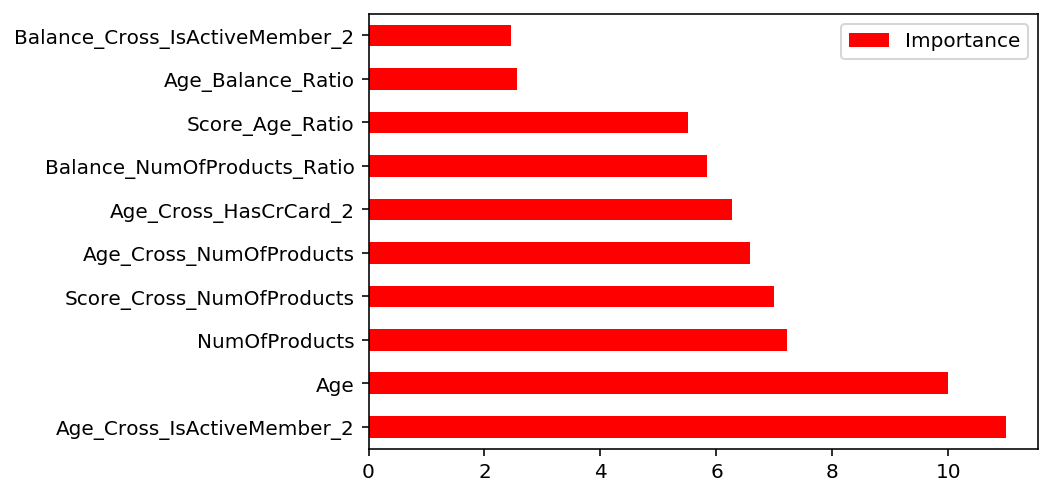

In [72]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = False).head(10).plot(kind ="barh", color = "r")

### 2-) XGBClassifier

In [75]:
model = XGBClassifier()

param_dist = {'n_estimators': [100, 200, 300],
              'subsample': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5],
              'learning_rate': [0.1, 0.02, 0.05],
              }
                             
xgb_cv_model = GridSearchCV(model, 
                            param_dist, 
                            cv = 3, 
                            verbose=10,
                            n_jobs =-1)

xgb_cv_model.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

In [76]:
xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_)

xgb_tuned.fit(X_train, y_train)

y_pred = xgb_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

0.8675

In [77]:
# Confusion matrix and Classification report
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
metrics.auc(fpr, tpr)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1528   67]
 [ 198  207]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.76      0.51      0.61       405

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



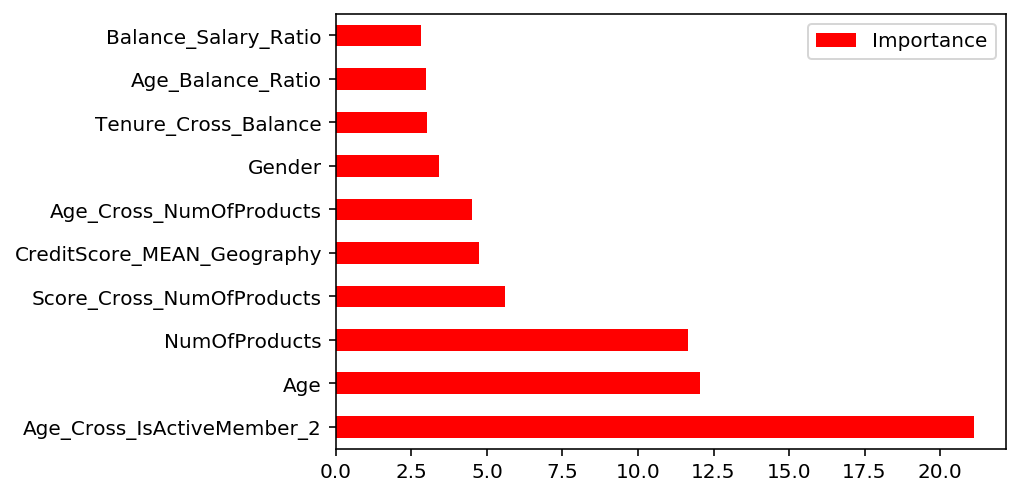

In [78]:
Importance = pd.DataFrame({"Importance": xgb_tuned.feature_importances_*100},
                            index = X_train.columns)

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = False).head(10).plot(kind ="barh", color = "r");

## 3-) LGBMClassifier

In [80]:
model = LGBMClassifier()

lgbm_params = {'n_estimators': [100, 500, 1000],
               'subsample': [0.6, 0.8, 1.0],
               'max_depth': [3, 4, 5],
               'learning_rate': [0.1, 0.02, 0.05],
               'min_child_samples': [5, 10, 20],
               }

lgbm_cv_model = GridSearchCV(model, 
                             lgbm_params, 
                             cv = 3, 
                             n_jobs = -1, 
                             verbose = 10)

lgbm_cv_model.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.02, 0.05],
                         'max_depth

In [84]:
lgbm_tuned = LGBMClassifier(**lgbm_cv_model.best_params_)

lgbm_tuned.fit(X_train, y_train)

y_pred = lgbm_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

0.867

In [85]:
# Confusion matrix and Classification report
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
metrics.auc(fpr, tpr)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[1520   75]
 [ 191  214]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.74      0.53      0.62       405

    accuracy                           0.87      2000
   macro avg       0.81      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



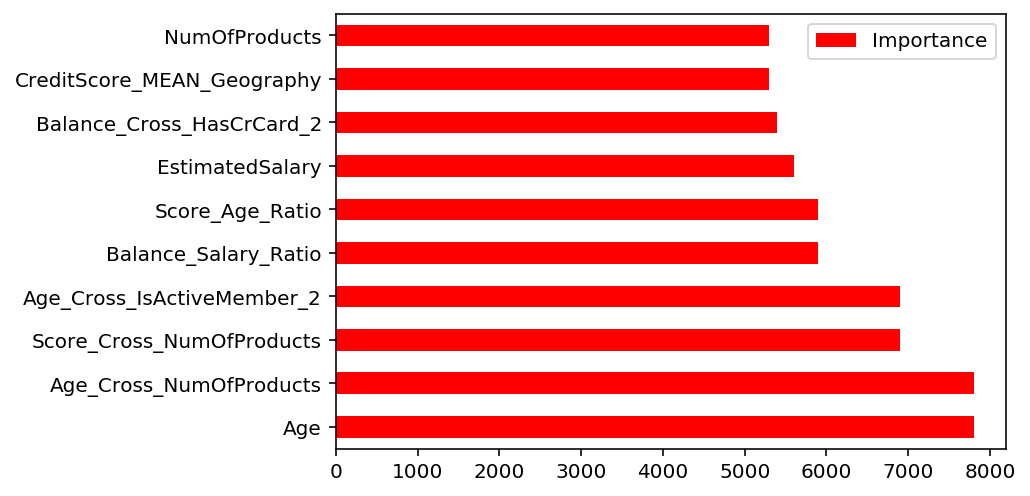

In [86]:
Importance = pd.DataFrame({"Importance": lgbm_tuned.feature_importances_*100},
                            index = X_train.columns)

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = False).head(10).plot(kind ="barh", color = "r")